<a href="https://colab.research.google.com/github/AmbiTyga/Task-Stylumia/blob/main/Model-Training_and_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading Dataset 
From Repository saved at EDA.ipynb

In [1]:
!wget https://raw.githubusercontent.com/AmbiTyga/Task-Stylumia/main/TrainValTest.7z

--2021-03-01 07:05:31--  https://raw.githubusercontent.com/AmbiTyga/Task-Stylumia/Basic/TrainTest.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10005411 (9.5M) [application/octet-stream]
Saving to: ‘TrainTest.7z’

TrainTest.7z        100%[===================>]   9.54M  30.6MB/s    in 0.3s    

2021-03-01 07:05:32 (30.6 MB/s) - ‘TrainTest.7z’ saved [10005411/10005411]



In [4]:
!7z x TrainValTest.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 9145122 bytes (8931 KiB)

Extracting archive: TrainValTest.7z
--
Path = TrainValTest.7z
Type = 7z
Physical Size = 9145122
Headers Size = 213
Method = LZMA2:24
Solid = +
Blocks = 1

  0%     41% 1 - train_parsed.csv                          79% 1 - train_parsed.csv                         Everything is Ok

Files: 3
Size:       51145612
Compressed: 9145122


## Downloading and importing packages

In [7]:
!pip install pytorch-nlp -q

     |████████████████████████████████| 92kB 3.9MB/s 


In [1]:
import pandas as pd
import numpy as np
import torch 
from torchtext import data
from torchtext.vocab import GloVe
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
train = pd.read_csv('/content/train_parsed.csv')
val = pd.read_csv('/content/val_parsed.csv')
test = pd.read_csv('/content/test_parsed.csv')

In [6]:
train['text'] = train['text'].apply(lambda x: " ".join([y for y in x.split() if y not in STOPWORDS]).lower())
val['text'] = val['text'].apply(lambda x: " ".join([y for y in x.split() if y not in STOPWORDS]).lower())
test['text'] = test['text'].apply(lambda x: " ".join([y for y in x.split() if y not in STOPWORDS]).lower())

In [8]:
def load_embed(file):
  '''
  Loads GLoVe embeddings
  file -> path to glove embeddings
  load_embed(...) -> Dict()
  '''
  def get_coefs(word,*arr): 
      return word, torch.from_numpy(np.array(arr,dtype=np.float32))
  
  embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='utf-8'))
      
  return embeddings_index

## Data Class and Data loader

In [9]:
from torchnlp.encoders.text import StaticTokenizerEncoder, pad_tensor

class MultiModalDataset(torch.utils.data.Dataset):
  def __init__(self,data):
    self.features = ['alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'frameTagRatio', 'html_ratio',
       'image_ratio', 'is_news', 'lengthyLinkDomain', 'linkwordscore',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'alchemy_labels',
       'tld_labels']
    self.data = data
    
    self.tokenizer = StaticTokenizerEncoder(data['text'].values, tokenize=lambda s: s.split())
    
  def __getitem__(self,i):
    text = pad_tensor(self.tokenizer.encode(self.data.loc[i,'text']),length=328)
    X = self.data.loc[i,self.features].astype(float).values
    y = self.data.loc[i,'label']

    return text,torch.FloatTensor(X),torch.FloatTensor([y])
  
  def __len__(self):
    return len(self.data)

In [10]:
# Get Word Index for the embedding weights
total_data = pd.concat([pd.read_csv('/content/train_parsed.csv'),
                        pd.read_csv('/content/val_parsed.csv')],ignore_index = True)
all = MultiModalDataset(total_data)
word_index = all.tokenizer.token_to_index
del all, total_data

In [11]:
# Train dataloader
train = pd.read_csv('/content/train_parsed.csv')
train_data = MultiModalDataset(train)
train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=29)

# Validation dataloader
val = pd.read_csv('/content/val_parsed.csv')
val_data = MultiModalDataset(val)
val_dataloader = torch.utils.data.DataLoader(val_data,batch_size=29)

In [12]:
# Loading GloVE embeddings
embeddings_index = load_embed('glove.840B.300d.txt')

# Saving embeddings for word from vocab
EMBEDDING_DIM = 300
embedding_matrix = torch.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Bilinear Network

In [61]:
class BiLinearModel(nn.Module):
  def __init__(self ,vocab_size,seq_length,feature_length,embedding_length,weights):
    super(BiLinearModel, self).__init__()

    # self.batch_size = batch_size
    # self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.em_len = embedding_length
    self.embedding_matrix = weights

    ## Textual Network
    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
    # self.lstm = nn.LSTM(embedding_length, hidden_size,bidirectional = True,num_layers=4)
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_length, nhead=6)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3)
    
    self.encoder_layer2 = nn.TransformerEncoderLayer(d_model=embedding_length, nhead=5)
    self.transformer_encoder2 = nn.TransformerEncoder(self.encoder_layer, num_layers=3)

    self.transformerNN = nn.Linear(seq_length,256)
    self.transformerBatchNorm = nn.BatchNorm1d(256)

    ## Numerical Features
    self.numericals = nn.Sequential(
        nn.Linear(feature_length,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU()
    )
    self.bn1 = nn.BatchNorm1d(32)

    ## Concatenation of Layers
    self.biNN = nn.Bilinear(32,256,128)
    self.dropout = nn.Dropout(0.4)
    self.fc1 = nn.Linear(128,32)
    self.bn2 = nn.BatchNorm1d(32)
    
    self.classifier = nn.Linear(32,1)


  def forward(self,X,text):
    # Textual
    text = self.word_embeddings(text)

    output = self.transformer_encoder(text)
    output = self.transformer_encoder2(output)

    output = output.mean(dim=2)

    output = self.transformerNN(output)
    output = self.transformerBatchNorm(output)

    ## Numerical
    vec = self.numericals(X)
    vec = self.bn1(vec)

    # Concatenate
    x = F.relu(self.biNN(vec,output))
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.bn2(x)
    x = self.classifier(x)
    
    return x


In [62]:
learning_rate = 1e-5
embedding_length = 300
word_embeddings = embedding_matrix
vocab_size = len(word_index)
device = torch.device('cuda')
sequence_length = 328
feature_length = 21

model = BiLinearModel(vocab_size,sequence_length,feature_length, embedding_length,word_embeddings)
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = learning_rate)
loss_fn = nn.BCEWithLogitsLoss().to(device)

model.cuda()

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(30):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_dataloader):
    text, X, target = batch
    text = text.to(device)
    X = X.to(device)
    target = target.to(device)
    optim.zero_grad()
    prediction = model(X,text)
    loss = loss_fn(prediction, target)
    num_corrects = ((prediction>0.5).float().view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    # clip_gradient(model, 1e-1)
    optim.step()
    steps += 1
    
    if steps % 50 == 0:
        print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()
  
  train_losses.append(train_epoch_loss/len(train_dataloader))
  train_accs.append(train_epoch_acc/len(train_dataloader))

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_dataloader):
      text, X, target = batch
      text = text.to(device)
      X = X.to(device)
      target = target.to(device)
      prediction = model(X,text)
      loss = loss_fn(prediction, target)
      num_corrects = ((prediction>0.5).float().view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))
      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1
  
  
  val_losses.append(val_epoch_loss/len(val_dataloader))
  val_accs.append(val_epoch_acc/len(val_dataloader))
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss/val_steps:3f}, Val. Acc: {val_epoch_acc/val_steps:.2f}% \n{90*'='}")

# Saving Model
torch.save(model.state_dict(), '/content/Model.bin')

	 Train - Epoch: 1, Idx: 50, Training Loss: 0.7778, Training Accuracy:  41.38%
	 Train - Epoch: 1, Idx: 100, Training Loss: 0.6892, Training Accuracy:  41.38%
	 Train - Epoch: 1, Idx: 150, Training Loss: 0.7177, Training Accuracy:  58.62%
	 Train - Epoch: 1, Idx: 200, Training Loss: 0.6385, Training Accuracy:  48.28%
Epoch: 01, Train Loss: 0.706, Train Acc: 49.76%, Val. Loss: 0.698678, Val. Acc: 48.68% 
	 Train - Epoch: 2, Idx: 50, Training Loss: 0.6690, Training Accuracy:  58.62%
	 Train - Epoch: 2, Idx: 100, Training Loss: 0.7166, Training Accuracy:  34.48%
	 Train - Epoch: 2, Idx: 150, Training Loss: 0.7796, Training Accuracy:  48.28%
	 Train - Epoch: 2, Idx: 200, Training Loss: 0.7152, Training Accuracy:  37.93%
Epoch: 02, Train Loss: 0.711, Train Acc: 48.95%, Val. Loss: 0.703062, Val. Acc: 48.68% 
	 Train - Epoch: 3, Idx: 50, Training Loss: 0.7415, Training Accuracy:  51.72%
	 Train - Epoch: 3, Idx: 100, Training Loss: 0.6953, Training Accuracy:  44.83%
	 Train - Epoch: 3, Idx: 15

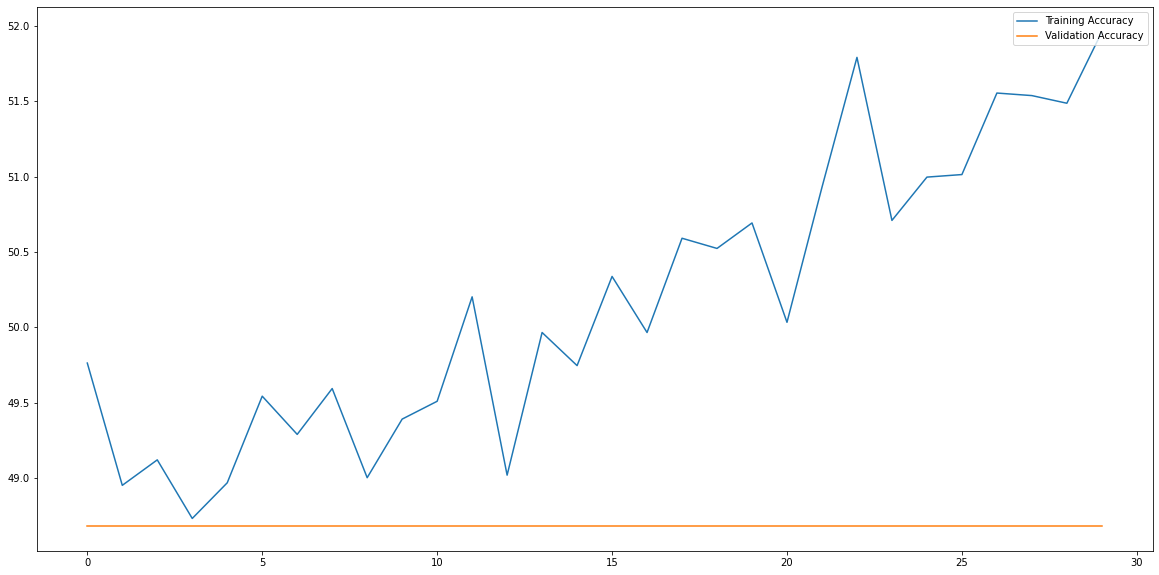

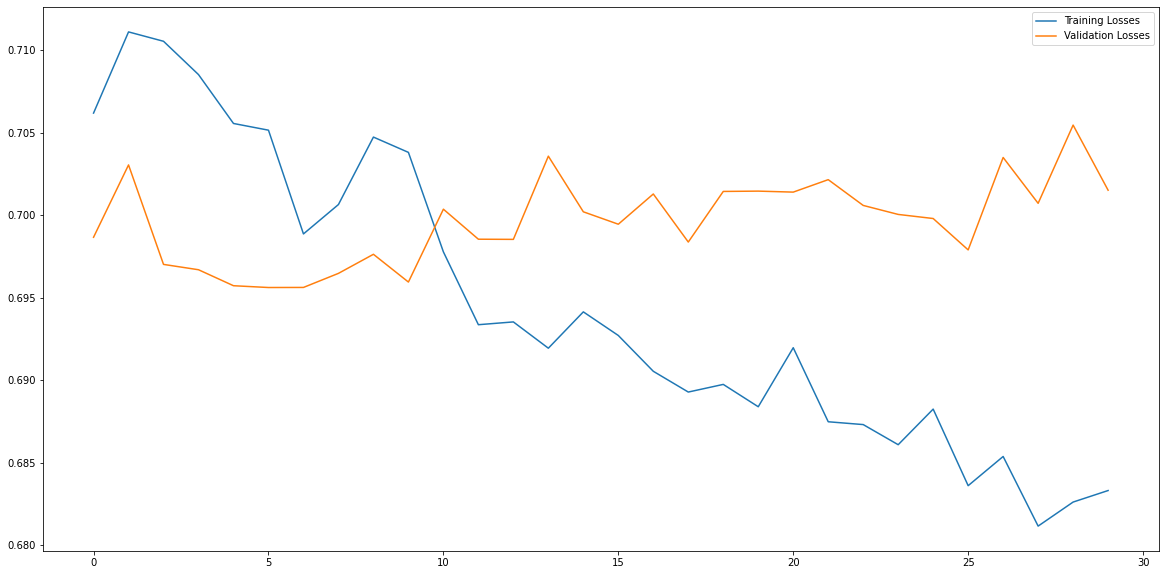

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.legend(loc = 'upper right')
plt.show()


plt.figure(figsize=(20,10))
plt.plot(train_losses,label='Training Losses')
plt.plot(val_losses,label='Validation Losses')
plt.legend(loc = 'upper right')
plt.show()

# Evaluation and Prediction

In [64]:
from sklearn.metrics import classification_report

In [99]:
val = pd.read_csv('/content/val_parsed.csv')
val_data = MultiModalDataset(val)
val_dataloader = torch.utils.data.DataLoader(val_data,batch_size=29)

In [ ]:
target.cpu().flatten().tolist()

In [ ]:
target.cpu().numpy().reshape(1,-1)[0]

In [100]:
model.cuda()
model.eval()

targets = []
predictions = []

val_iterator = iter(val_dataloader)
for idx,batch in enumerate(val_dataloader):
  with torch.no_grad():
    text, X, target = batch
    text = text.to(device)
    X = X.to(device)
    target = target.to(device)

    prediction = model(X,text)
    targets
    loss = loss_fn(prediction, target)

  targets += target.cpu().flatten().tolist()
  predictions += (prediction>0.5).float().cpu().flatten().tolist()

print(classification_report(targets,predictions))

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.65       720
         1.0       0.00      0.00      0.00       759

    accuracy                           0.49      1479
   macro avg       0.24      0.50      0.33      1479
weighted avg       0.24      0.49      0.32      1479



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


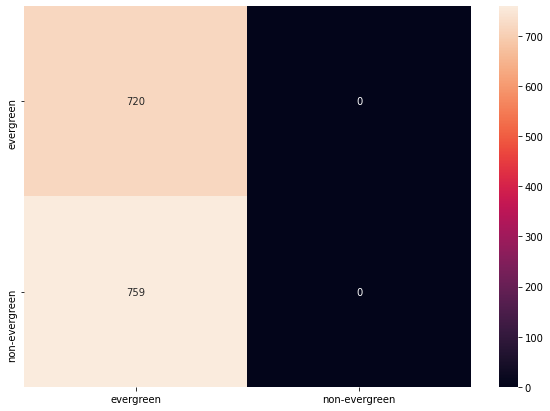

In [108]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(targets,predictions)
cf = pd.DataFrame(cf, index = ['evergreen','non-evergreen'],
                  columns = ['evergreen','non-evergreen'])
plt.figure(figsize = (10,7))
sn.heatmap(cf, annot=True,fmt='.3g')
plt.show()